## David Liu
## BAN 676

## QUESTION 2:

#### Build a CNN Classification Model to classify species from the Orchid Flowers dataset (Use train and validation data for respective purpose, no testing needed)

#### (1) Model 2: Use Transfer learning or fine tuning

In [221]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

2.3.0


## Preliminary Steps

### (All preliminary steps are the same as in question 1, with the CNN model.)
Checking to see how many images are in the entire orchid data directory

In [222]:
# There should be 7156 images. However, since 4 images were originally jfif formatted and later re-saved as jpeg files, we have 4
# extra images, totaling 7160.

orchid_directory = "Orchid Flowers Dataset-v1.1/Orchid_Images"

file_names = os.listdir(orchid_directory)
print(len(file_names), "images")

7160 images


Putting together a dataframe that shows the image file names and their associated labels. This dataframe will be used later to build an image dataset with associated labels.

In [223]:
img_label = pd.read_csv("Orchid Flowers Dataset-v1.1/Species_Classifier/ClassLabels.txt", header=None)
img_label.columns = ["Images","Labels"]
img_label["Labels"] = img_label["Labels"].astype(str)
img_label

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
7151,7152.jpeg,63
7152,7153.jpeg,63
7153,7154.jpeg,63
7154,7155.jpg,63


Identifying all image files' formats in the image folder. The tensorflow functions, flow_from_dataframe() and ImageDataGenerator(), which will be used later to create an image dataset, only accepts jpeg, png, bmp, and gif image formats.

In [224]:
file_names_df = pd.DataFrame(file_names)
file_names_df[0] = file_names_df[0].str.extract("[0-9]+.(.*)")
file_names_df_dummies = pd.get_dummies(file_names_df[0])
file_names_df_dummies.sum()

jfif       4
jpeg      34
jpg     7122
dtype: int64

Shown above, there are 4 jfif images, which not an acceptable image format. These images will be converted to jpeg.

In [225]:
deviant_files = []

for each in file_names:
    if each.endswith(".jfif") == True:
        deviant_files.append(each)

print(deviant_files)
  

['7067.jfif', '7068.jfif', '7069.jfif', '7071.jfif']


The 4 jfif files - '7067.jfif', '7068.jfif', '7069.jfif', and '7071.jfif' - are converted to jpg, and resaved into the image folder.

In [226]:
for each in deviant_files:
    im = Image.open(orchid_directory + "/" + each)
    im.save(orchid_directory + "/" + each.split(".")[0] + ".jpg")

The file names with the .jfif format extension in the img_label dataframe will be converted to the .jpg format extension. The strings under the "Images" column in the img_label dataframe will be used as directory names that points to an image file in the image folder. Therefore, the strings must match the image filenames in the image folder directory.  

In [227]:
for index in range(len(img_label)):
    if img_label.iloc[index,0] in deviant_files:
        img_label.iloc[index,0] = img_label.iloc[index,0].split(".")[0] + ".jpg"

Identifying all image formats in the orchid image folder again.

In [228]:
formats = img_label["Images"].str.extract("[0-9]+.(.*)")

formats_dummies = pd.get_dummies(formats[0])
formats_dummies.sum()


jpeg      34
jpg     7122
dtype: int64

Few lines from the img_label dataframe

In [229]:
img_label.head(20)

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
5,6.jpg,1
6,7.jpg,1
7,8.jpg,1
8,9.jpg,1
9,10.jpg,1


## Split Training/Validation Data

### (All data splitting steps are the same as in question 1, with the CNN model.)

Extracting the data again, and splitting them into training and validation data. Extracted images are resized to 256 x 256 in order to accommodate the majority of image sizes in the data directory. The number of classes shown in the outputs below are inferred by the function. 

In [230]:
image_data=ImageDataGenerator(rescale=1./255.,validation_split=0.3)

In [231]:
orchid_img_train = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "training",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (256,256),
)

Found 5010 validated image filenames belonging to 156 classes.


In [232]:
orchid_img_val = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "validation",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (256,256),
)

Found 2146 validated image filenames belonging to 156 classes.


Displaying some images from the training and validation datasets. The purpose of this is to get an idea of what the images look like, and to determine whether there might be possible issues as a result of the images being resized.

Training Data

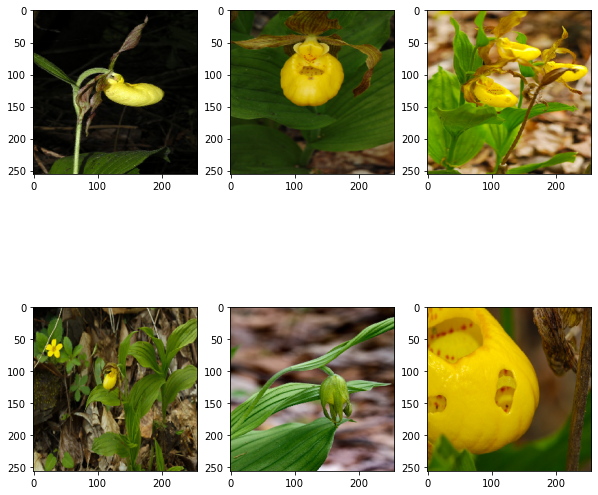

In [233]:
x,y = orchid_img_train.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

Validation Data

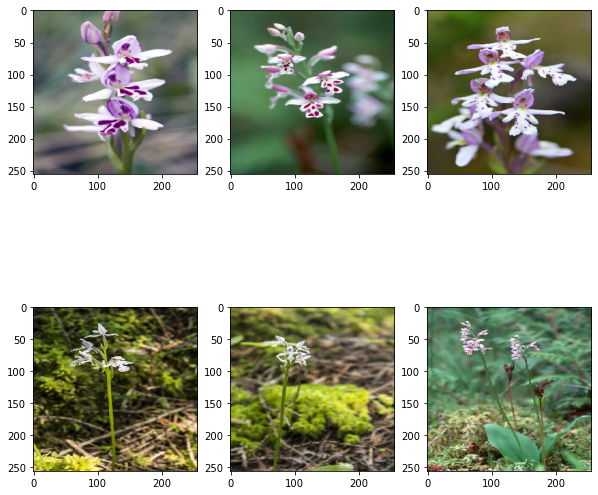

In [234]:
#help(orchid_img_val)
x,y = orchid_img_val.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

## Building the Transfer Learning Model

This transfer learning model will be built with VGG16.

In [245]:
t_model.reset_states()
tf.keras.backend.clear_session()

In [246]:
t_model = tf.keras.applications.VGG16(include_top = False, input_shape=(256,256,3))

for layer in t_model.layers:
    layer.trainable = False

flat_layer = tf.keras.layers.Flatten()(t_model.layers[-1].output)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(flat_layer)
dropout_layer = tf.keras.layers.Dropout(0.50)
output_layer = tf.keras.layers.Dense(156, activation="softmax")(dense_layer)

t_model = tf.keras.Model(inputs=t_model.inputs, outputs=output_layer)

t_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

Calculating the naive model accuracy. This is a categorical problem. In order to find a decent baseline accuracy for which the CNN model must exceed, we will find the proportion of the category with the highest rate of occurrence. The highest proportion will be used as the baseline accuracy.  

In [156]:
total = img_label["Images"].count()

max_prob_category = img_label.groupby(["Labels"]).agg("count").reset_index()

max_prob_category = max(max_prob_category["Images"])

baseline_acc = max_prob_category/total

baseline_acc

0.052124091671324764

In [247]:
t_model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [248]:
train_step = orchid_img_train.n//orchid_img_train.batch_size
val_step = orchid_img_val.n//orchid_img_val.batch_size

t_history = t_model.fit_generator(generator = orchid_img_train, 
                                steps_per_epoch = train_step,
                                validation_data = orchid_img_val, 
                                validation_steps = val_step,
                                epochs=10)

Epoch 1/10
156/156 [==============================] - 773s 5s/step - loss: 5.1014 - accuracy: 0.0323 - val_loss: 5.6774 - val_accuracy: 0.0000e+00
Epoch 2/10
156/156 [==============================] - 769s 5s/step - loss: 4.6178 - accuracy: 0.0470 - val_loss: 6.0278 - val_accuracy: 0.0275
Epoch 3/10
156/156 [==============================] - 773s 5s/step - loss: 4.4415 - accuracy: 0.0651 - val_loss: 5.8867 - val_accuracy: 0.0229
Epoch 4/10
156/156 [==============================] - 775s 5s/step - loss: 4.2211 - accuracy: 0.1211 - val_loss: 6.5428 - val_accuracy: 0.0238
Epoch 5/10
156/156 [==============================] - 779s 5s/step - loss: 4.0322 - accuracy: 0.1488 - val_loss: 6.7568 - val_accuracy: 0.0616
Epoch 6/10
156/156 [==============================] - 776s 5s/step - loss: 3.8606 - accuracy: 0.1842 - val_loss: 6.8434 - val_accuracy: 0.0373
Epoch 7/10
156/156 [==============================] - 785s 5s/step - loss: 3.6665 - accuracy: 0.2079 - val_loss: 7.4379 - val_accuracy: 0.

Plotting the training and validation prediction accuracy over epochs

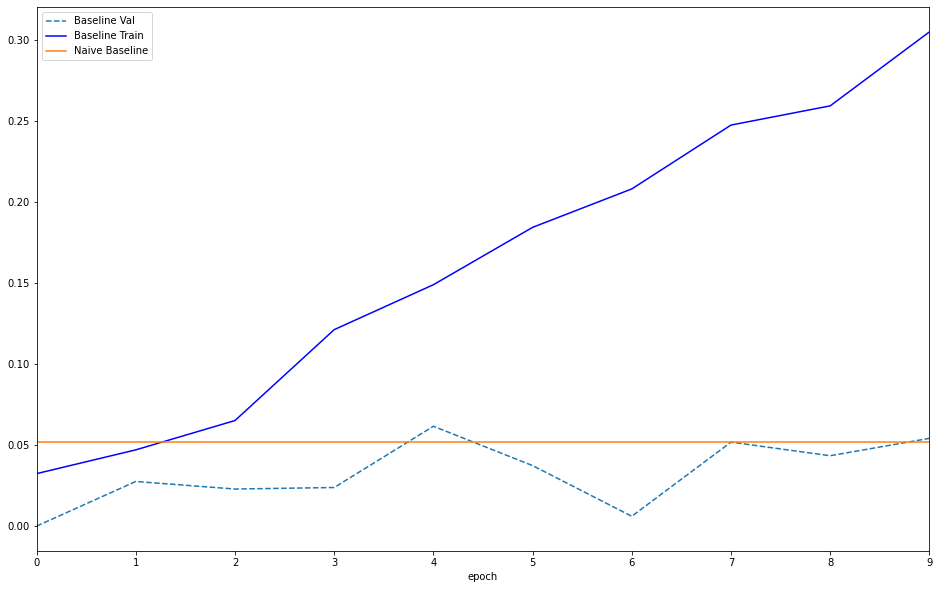

In [250]:
plt.figure(figsize=(16,10))
plt.plot(t_history.epoch, t_history.history['val_accuracy'],'--', label='Baseline Val')
plt.plot(t_history.epoch, t_history.history['accuracy'], color='blue', label='Baseline Train')
plt.plot([0,10], [baseline_acc, baseline_acc], label = 'Naive Baseline')
plt.xlabel("epoch")
plt.xlim([0,max(t_history.epoch)])
#plt.ylim([0,1])
plt.legend()
plt.show()

## Final Analysis
The transfer learning model above uses the VGG16 model. The output layer was taken out and replaced with a flattened dense layer with 512 nodes with ReLu activation, a dropout function, and a softmax 156 output layer. The VGG16 model layers were specified to not train during the model fitting iterations; only the added layers were trained in order to adapt the layers 
to the weights in the VGG16 model layers. Similar to the CNN model in question 1, each image that goes through the model is sized 256x256 pixels. As shown by the graph above, the transfer learning model performed better than the 0.052, or 5.2% accuracy, baseline by the end of the 10th epoch, with a training data prediction accuracy of 0.3047 and a validation prediction accuracy of 0.0541. Notably, the validation accuracy is much lower than the training data accuracy, which is a clear sign of overfitting. However, similar to the CNN model results, the training data accuracy is shown to be increasing with each model fitting iteration, which shows that the training accuracy has not plateaued. This implies that the model might become more accurate given more epochs.
